# Accounting for Larmor-Scale Fluctuations

We want to quantify the effect Larmor-scale fluctuations have on the observed macroscopic values of $j_\nu$ or $\alpha_\nu$.  This file provides a sample procedure one could use to incorporate knowledge of the Larmor-scale structure of the magnetic field $\bf{B}$ and the electron number density $n_e$ in order to provide more accurate synchrotron emissivities and absorptivities.

First we need to specify the path of the symphony ${\tt /build/}$ folder.  Replace the path below with the correct path for your machine.

In [1]:
symphony_build_path = '/home/alex/Documents/Spring_2016/symphony/symphony/build'

The next cell will import all of the necessary libraries (including symphony).  It will also set some matplotlib plot parameters to make nice-looking plots.

In [2]:
%matplotlib inline

#import symphony to use exact integrator or fitting formulae
import sys
sys.path.append(symphony_build_path)
import symphonyPy as sp

#import other useful libraries
import numpy as np
import pylab as pl
import numpy.random as random
from numpy.random import normal
import scipy.special as special
from scipy.interpolate import splrep, splev, interp1d
from statsmodels.nonparametric.kde import KDEUnivariate
from scipy.stats.distributions import norm
from scipy.optimize import curve_fit

# Set plot parameters to make beautiful plots
pl.rcParams['figure.figsize']  = 12, 7.5
pl.rcParams['lines.linewidth'] = 1.5
pl.rcParams['font.family']     = 'serif'
pl.rcParams['font.weight']     = 'bold'
pl.rcParams['font.size']       = 20  
pl.rcParams['font.sans-serif'] = 'serif'
pl.rcParams['text.usetex']     = True
pl.rcParams['axes.linewidth']  = 1.5
pl.rcParams['axes.titlesize']  = 'medium'
pl.rcParams['axes.labelsize']  = 'medium'

pl.rcParams['xtick.major.size'] = 8     
pl.rcParams['xtick.minor.size'] = 4     
pl.rcParams['xtick.major.pad']  = 8     
pl.rcParams['xtick.minor.pad']  = 8     
pl.rcParams['xtick.color']      = 'k'     
pl.rcParams['xtick.labelsize']  = 'medium'
pl.rcParams['xtick.direction']  = 'in'    

pl.rcParams['ytick.major.size'] = 8     
pl.rcParams['ytick.minor.size'] = 4     
pl.rcParams['ytick.major.pad']  = 8     
pl.rcParams['ytick.minor.pad']  = 8     
pl.rcParams['ytick.color']      = 'k'     
pl.rcParams['ytick.labelsize']  = 'medium'
pl.rcParams['ytick.direction']  = 'in'

## Importing Data

The following two cells deal with importing the simulation data.  In the first, choose the path to the folder containing the data files.  The value of num_skip determines the number of data points sampled from the data files; for example, $\tt{num\_skip = 32}$ will sample every 32nd point from the data files.  To sample every point, choose $\tt{num\_skip = 1}$.  By default, the magnetic field is normalized to its initial value from the start of the simulation; it can be scaled to a value in Gauss by setting $\tt{B\_scale}$.  Finally, there is a place to choose the value of $\bf{k}$; this is the direction from which the observer is looking at the simulation plane (which is the x-y plane).  $\bf{k}$ does not have to be normalized.

In [3]:
datafiles_path = '/home/alex/Documents/Spring_2016/'

num_skip = 32
B_scale  = 30.
obs_vector = [1, 0, 0] #choose observer vector; does not have to be normalized (normalization taken care of below)

In [20]:
#import data

#datafiles_path = '/home/mani/work/kunz_data/'
B_x = np.loadtxt(datafiles_path + 'mirror_bx.out')[::num_skip, ::num_skip] * B_scale
B_y = np.loadtxt(datafiles_path + 'mirror_by.out')[::num_skip, ::num_skip] * B_scale
B_z = np.loadtxt(datafiles_path + 'mirror_bz.out')[::num_skip, ::num_skip] * B_scale
n_e = np.loadtxt(datafiles_path + 'mirror_d.out')[::num_skip, ::num_skip]
B_mag = np.sqrt(B_x**2. + B_y**2. + B_z**2.)

obs_angle  = np.zeros(np.shape(B_x))
for i in range(0, np.shape(B_x)[0]):
    for j in range(0, np.shape(B_x)[1]):
        B_vector = [B_x[j][i], B_y[j][i], B_z[j][i]]
        obs_angle[j][i] = np.arccos(np.dot(B_vector, obs_vector) / (np.linalg.norm(B_vector) 
                                                                    * np.linalg.norm(obs_vector)))

mean_B_vector = [np.mean(B_x), np.mean(B_y), np.mean(B_z)]
angle_to_mean_field = np.arccos(np.dot(mean_B_vector, obs_vector) / (np.linalg.norm(mean_B_vector) 
                                                                     * np.linalg.norm(obs_vector)))

print np.mean(obs_angle), angle_to_mean_field

0.968412126105 0.98157818986


## $\overline{j_\nu(B, \theta, n_e)}$ vs. $j_\nu(\overline{B}, \overline{\theta}, \overline{n}_e)$

We first want to quantify the differences between the spatially-averaged emissivity, $\overline{j_\nu(B, \theta, n_e)}$, and the emissivity evaluated using spatially-averaged values of the relevant fluctuating quantities $j_\nu(\overline{B}, \overline{\theta}, \overline{n}_e)$.  The first cell below allows one to choose the electron energy distribution function, polarization (component of the Stokes vector), radiation frequency, and various distribution function parameters.  The second cell below directly evaluates both quantities and determines the relative difference between them

$ \Delta j_\nu = \frac{\big| \overline{j_\nu(B, \theta, n_e)} - j_\nu(\overline{B}, \overline{\theta}, \overline{n}_e) \big|}{\overline{j_\nu(B, \theta, n_e)}}$.

In [5]:
#define constants in Gaussian CGS units
m         = 9.1093826e-28
c         = 2.99792458e10
e         = 4.80320680e-10
h         = 6.6260693e-27

#-------------------set symphony's parameters---------------#
#calculates j_nu if True, alpha_nu if false
emiss            = True

#choose frequency nu in Hz
nu = 230e9

#polarization as component of S = {I,Q,U,V}
stokes_parameter = sp.STOKES_I

#sp.POWER_LAW, sp.MAXWELL_JUETTNER, or sp.KAPPA_DIST
distribution     = sp.POWER_LAW

#dimensionless electron temperature for MAXWELL_JUETTNER (thermal) distribution
theta_e          = 10.

#parameters for the power-law distribution (index is p)
gamma_min        = 1.
gamma_max        = 1000.
gamma_cutoff     = 1e10
p                = 3.

#parameters for the kappa distribution
kappa            = 3.5
w                = 10.

#all emissivities have a dimensional prefactor times a dimensionless term;
#norm is the dimensional term; divide the emissivites by norm to get dimensionless results
norm_j_nu = np.mean(n_e) * e**2. * (e * np.mean(B_mag) / (2. * np.pi * m * c)) / c
norm_alpha_nu = np.mean(n_e) * e**2. / (nu * m * c)

#a wrapper for symphony's fitting formulae function
def j_nu_or_alpha_nu(nu, obs_angle, B_mag, n_e, stokes_parameter):
    
    #in symphony's coordinates STOKES_U = 0; use STOKES_Q and apply rotation below
    if stokes_parameter == sp.STOKES_U:
        stokes_parameter = sp.STOKES_Q
    
    if emiss == True:
        return np.vectorize(sp.j_nu_fit_py)(nu, B_mag, n_e, obs_angle, distribution, 
                              stokes_parameter, theta_e, p, gamma_min, 
                              gamma_max, gamma_cutoff, kappa, w) / norm_j_nu
    else:
        return np.vectorize(sp.alpha_nu_fit_py)(nu, B_mag, n_e, obs_angle, distribution, 
                                  stokes_parameter, theta_e, p, gamma_min, 
                                  gamma_max, gamma_cutoff, kappa, w) / norm_alpha_nu


alpha = np.arccos(1. * B_x / B_mag)    
beta  = np.arccos(1. * B_y / B_mag)
alpha_mean = np.arccos(1. * np.mean(B_x) / np.mean(B_mag))
beta_mean  = np.arccos(1. * np.mean(B_y) / np.mean(B_mag))


exact_j_nu_array = j_nu_or_alpha_nu(nu, obs_angle, B_mag, n_e, stokes_parameter)
j_nu_avgs = j_nu_or_alpha_nu(nu, angle_to_mean_field, np.mean(B_mag), np.mean(n_e), stokes_parameter)

if stokes_parameter == sp.STOKES_Q:
    exact_j_nu_array = exact_j_nu_array * np.cos(alpha) * np.cos(2. * beta)
    j_nu_avgs        = j_nu_avgs * np.cos(alpha_mean) * np.cos(2. * beta_mean)
elif stokes_parameter == sp.STOKES_U:
    exact_j_nu_array = exact_j_nu_array * np.cos(alpha) * np.sin(2. * beta)
    j_nu_avgs        = j_nu_avgs * np.cos(alpha_mean) * np.sin(2. * beta_mean)


j_nu_exact = np.mean(exact_j_nu_array)
    
print 'j_nu_exact: ', j_nu_exact, ' j_nu_avgs: ', j_nu_avgs, ' Delta j_nu: ', 
print np.abs((j_nu_exact - j_nu_avgs)/j_nu_exact)

j_nu_exact:  0.00103712475407  j_nu_avgs:  0.000861732506108  Delta j_nu:  0.169113934722


The above cell calculates $\Delta j_\nu$ for the fiducial power-law distribution, which should come out to nearly 17% for Stokes I (intensity).  We can understand where this deviation comes from by defining the following quantities

$B = \overline{B} + \delta B$ 

$\sin(\theta) = \overline{\sin(\theta)} + \delta \sin(\theta)$

$n_e = \overline{n}_e + \delta n_e$

and by studying the dependences of the power-law emissivity for parameter $p = 3$

$j_\nu \propto n_e B^{2} \sin(\theta)^{2}$.

We now can expand this equation out using the above definitions; it is also important to note that by definition terms linear in "$\delta$" quantities average to zero.  Correlations between fluctuating quantities are incorporated through terms such as $\overline{n_e B}$; assuming that correlations are unimportant, the emissivity becomes

$\overline{j_\nu(B, \theta, n_e)} \propto j_\nu(\overline{B}, \overline{\theta}, \overline{n}_e)+ \overline{\overline{n}_e (\delta B)^2 \overline{\sin(\theta)}^2}+ \overline{\overline{n}_e \overline{B}^2 (\delta \sin(\theta))^2} + \overline{\overline{n}_e (\delta B)^2 (\delta \sin(\theta))^2}$

so the contributions to $\Delta j_\nu$ must come from the latter three terms (and correlation terms, which we have dropped).  The cell below confirms this notion, and illustrates that in this case correlations only amount $\Delta j_\nu$ of 3.5%.

In [6]:
avg_B   = np.mean(B_mag)
delta_B = B_mag - avg_B

#avg_st   = np.mean(np.sin(obs_angle))
avg_st   = np.sin(angle_to_mean_field)
delta_st = np.sin(obs_angle) - avg_st

avg_n_e = np.mean(n_e)
delta_n_e = n_e - avg_n_e

def j_nu_PL_3(B, st, n_e):
    ans = n_e * B**2. * st**2.
    return ans

j_nu_exact = np.mean(j_nu_PL_3(B_mag, np.sin(obs_angle), n_e))
j_nu_avg   = j_nu_PL_3(avg_B, avg_st, avg_n_e)
term2      = np.mean(avg_n_e * delta_B**2. * avg_st**2.)
term3      = np.mean(avg_n_e * avg_B**2. * delta_st**2.)
term4      = np.mean(avg_n_e * delta_B**2. * delta_st**2.)

print 'exact:                            ', j_nu_exact, ' avg:   ', j_nu_avg
print 'Delta j_nu:                       ', (j_nu_exact - j_nu_avg)/j_nu_exact
print 'Delta j_nu including other terms: ', np.abs(j_nu_exact - (j_nu_avg + term2 + term3 + term4))/j_nu_exact

print '\n------------------------Correlation effects---------------------------\n'
print 'avg(delta_B, delta_sin_theta, delta_n_e) = ', np.mean(delta_B), np.mean(delta_st), np.mean(delta_n_e)
print 'avg(delta_B * delta_n_e)        ', np.mean(delta_B * delta_n_e)
print 'avg(delta_B * delta_sin_theta)  ', np.mean(delta_B * delta_st)
print 'avg(delta_sin_theta * delta_n_e)', np.mean(delta_st * delta_n_e)

exact:                             1989.92765215  avg:    1653.40315709
Delta j_nu:                        0.169113934722
Delta j_nu including other terms:  0.00935476811833

------------------------Correlation effects---------------------------

avg(delta_B, delta_sin_theta, delta_n_e) =  2.50362145282e-14 -0.0188416837261 2.59394700507e-16
avg(delta_B * delta_n_e)         -0.0637101324066
avg(delta_B * delta_sin_theta)   0.568587949505
avg(delta_sin_theta * delta_n_e) -7.77202306422e-05


## Determining Size of Spatial Correlations

The first assumption we would like to make is that the spatial correlations between fluctuating quantities are small.  In order to do this, we first recognize that [FILL IN REST OF THIS]

## Analyzing $B$, $\theta$, $n_e$ Distributions

In order to produce averaged emissivities and absorptivities which take Larmor-scale fluctuations into account, we first need to understand the distributions of the fluctuating quantities $B$ (the magnitude of the magnetic field) $\theta$ (the observer angle) and $n_e$ (the electron number density).

### The $\theta$ Distribution

The observer angle $\theta$ is defined to be the angle between the wavevector $\bf{k}$ and the local magnetic field $\bf{B}$.  The distribution of $\theta$ is nearly a Gaussian.  The code below fits the mean and standard deviation of this Gaussian and plots the fit along with the data itself.

Fitted mean               =  0.975332004086
Fitted standard deviation =  0.140546615055


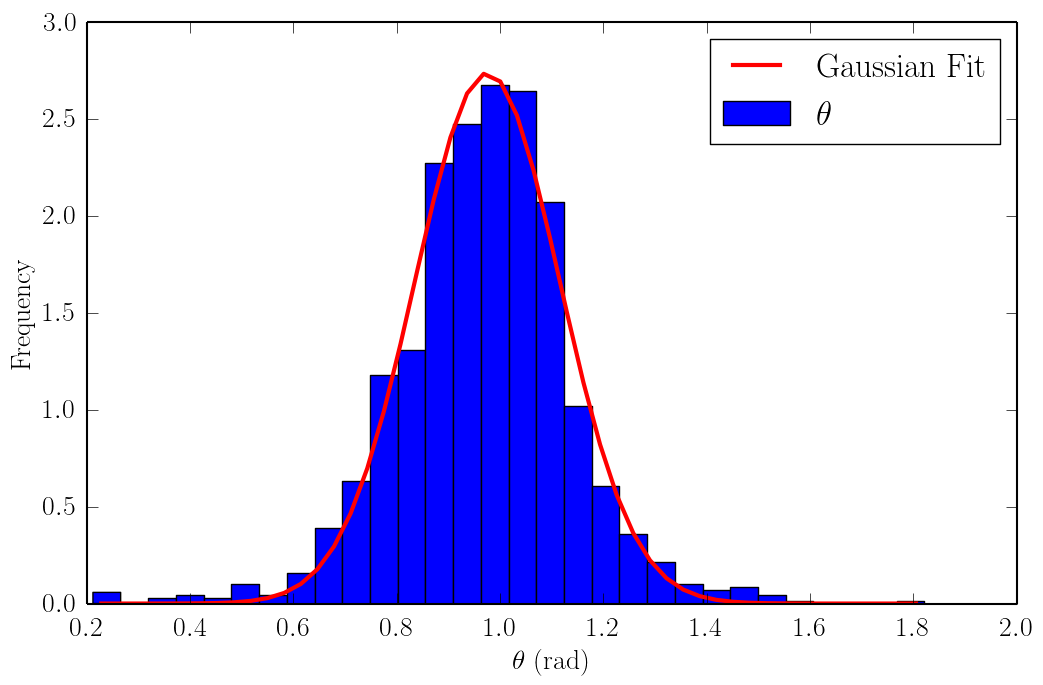

In [7]:
#fit Gaussian probability distribution to obs_angle distribution
data = obs_angle.flatten()
hist, bin_edges = np.histogram(data, density=True, bins=50)
bin_centres = (bin_edges[:-1] + bin_edges[1:])/2

# Define model function to be used to fit to the data above:
def gauss(x, *p):
    A, mu, sigma = p
    return A*np.exp(-(x-mu)**2/(2.*sigma**2))

# p0 is the initial guess for the fitting coefficients (A, mu and sigma above)
p0 = [1., 0., 1.]

coeff, var_matrix = curve_fit(gauss, bin_centres, hist, p0=p0)

# Get the fitted curve
hist_fit = gauss(bin_centres, *coeff)

#pl.plot(bin_centres, hist, label='$\\mathrm{Input~data}$')
#pl.plot(bin_centres, hist_fit, label='$\\mathrm{Gaussian~Fit}$')
#pl.xlabel('$\\theta$')
#pl.ylabel('$\\mathrm{Frequency}$')

fit_mu    = coeff[1]
fit_sigma = coeff[2]

#pl.show()
pl.hist(obs_angle.flatten(), bins=30, normed=True, label='$\\theta$')
pl.plot(bin_centres, hist_fit, label='$\\mathrm{Gaussian~Fit}$', lw=3, c='r')
pl.xlabel('$\\theta \\mathrm{~(rad)}$')
pl.ylabel('$\\mathrm{Frequency}$')

# Finally, lets get the fitting parameters, i.e. the mean and standard deviation:
print 'Fitted mean               = ', fit_mu
print 'Fitted standard deviation = ', fit_sigma 
pl.legend()
pl.show()

### The $B$ Distribution

The distribution of the magnitude of the magnetic field $B$ is bimodal in this case and not easily fit by any standard distribution function.  We can achieve an approximation to the true $B$ distribution in this case using a Kernel Density Estimation (KDE) algorithm.   

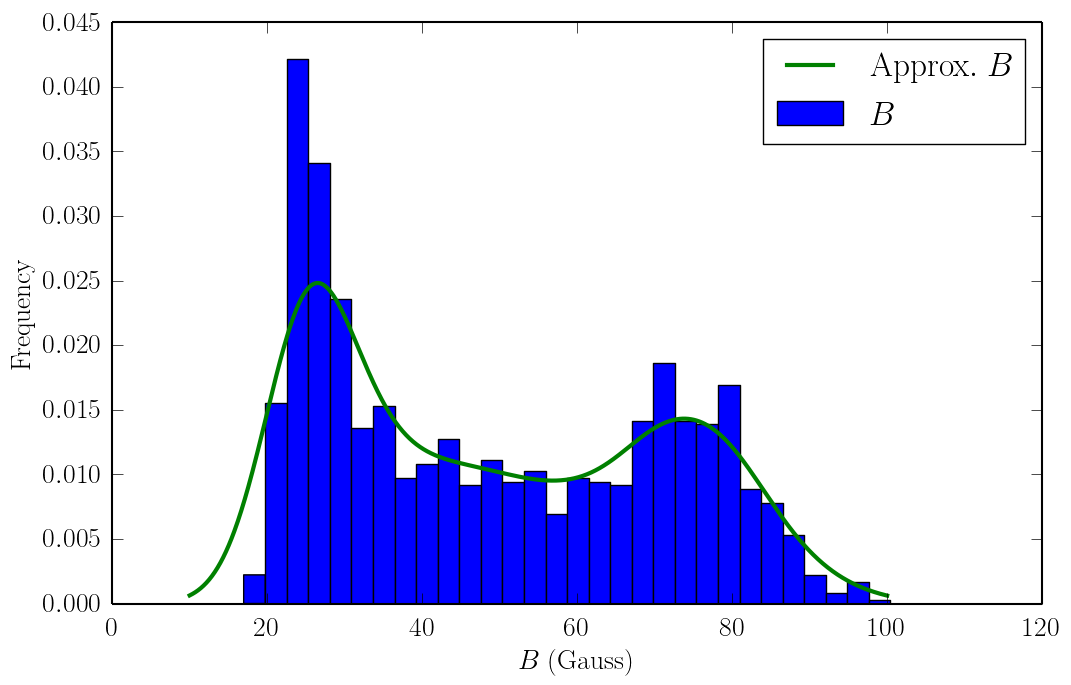

In [8]:
def kde_statsmodels_u(x, x_grid, bandwidth=0.2, **kwargs):
    """Univariate Kernel Density Estimation with Statsmodels"""
    kde = KDEUnivariate(x)
    kde.fit(bw=bandwidth, **kwargs)
    return kde.evaluate(x_grid)

from scipy.interpolate import splrep, splev, interp1d
# The grid we'll use for plotting
min_x = 10.
max_x = 100.
num_points = 1000
x_grid = np.linspace(min_x, max_x, num_points)

bandwith_set = 5.

# Draw points from a bimodal distribution in 1D
np.random.seed(0)
x = B_mag.flatten()

pdf = kde_statsmodels_u(x, x_grid, bandwidth=bandwith_set)

width_of_step = (max_x - min_x) / num_points
cdf = np.cumsum(pdf) * width_of_step
tck = splrep(x_grid, cdf)
tck_inv = splrep(cdf, x_grid)

#need to remove erroneous values of approximate_dist that are greater than max(B_mag)
approximate_dist = splev(np.random.rand(1296+6, 1).flatten(), tck_inv)
approximate_dist = approximate_dist[approximate_dist < np.amax(B_mag)]
#print np.amax(approximate_dist)

#pl.hist(approximate_dist, bins=30, normed=True, label='$\\mathrm{approx.~dist.}$');
pl.hist(B_mag.flatten(),  bins=30, normed=True, label='$B$');
pl.plot(x_grid, pdf, linewidth=3, label='$\\mathrm{Approx.~}B$')
pl.legend(loc='upper right')
pl.xlabel('$B\\mathrm{~(Gauss)}$')
pl.ylabel('$\\mathrm{Frequency}$')

### The $n_e$ Distribution

The distribution of electron number density across the simulation is very nearly constant, with variations on the order of 1%.  The cell below plots $n_e$ to illustrate this point.  Since the fluctuations in $n_e$ are so small, we can simply use its spatially-averaged value (which is equivalent to using a uniform distribution at this value).

<matplotlib.colorbar.Colorbar instance at 0x7fdca535f1b8>

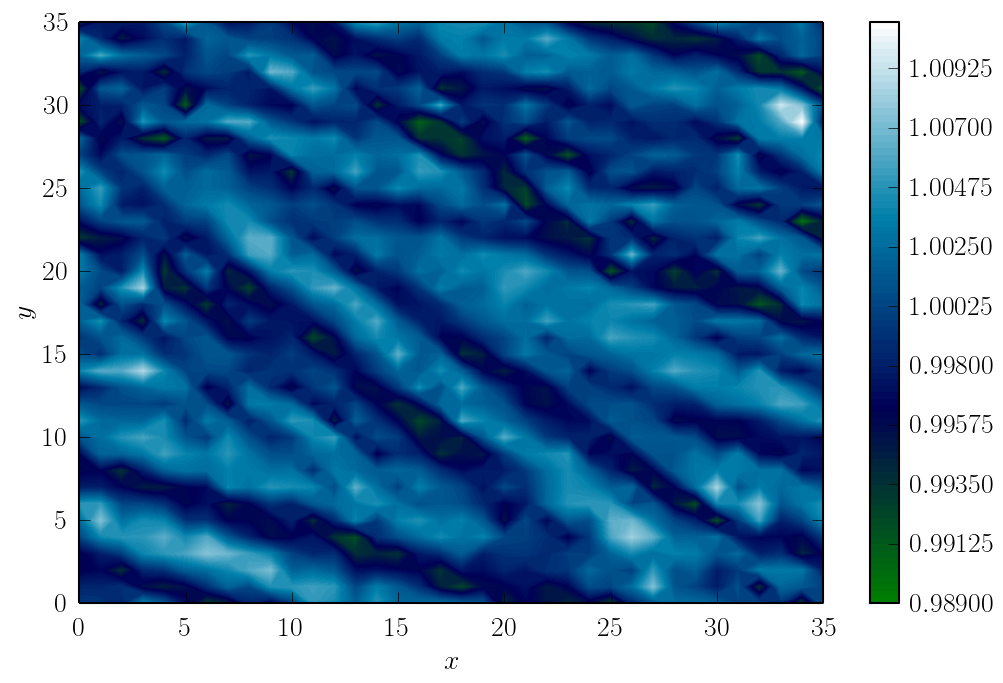

In [9]:
pl.contourf(n_e, 100, cmap='ocean')
pl.xlabel('$x$')
pl.ylabel('$y$')
pl.colorbar()

## Testing the Various Approximations

Now we will check the effect the various approximations ($\theta$ as a Gaussian, our $B$ KDE fit, and a uniform distribution for $n_e$) have on the emissivities and absorptivities as calculated by symphony.  The cell below will calculate the relative difference between the exact quantities (evaluated at each grid zone and then averaged) and the averaged quantities (evaluated once using the spatial averages of $B$, $\theta$, $n_e$).  We quantify this relative difference for the emissivity as

$D(j_\nu) = \frac{|j_\nu^{exact} - j_\nu^{avg}|}{j_\nu^{exact}}$

where $D(\alpha_\nu)$ is defined analogously.

In [27]:
#We now want to calculate j_nu() using theta sampled from an approximation to its
# actual distribution (a Gaussian).  We want to do the same with the distribution
# of |B|, though before we do that we need to figure out how to randomly sample
# numbers from the KDE approximate PDF for |B|.

size = len(obs_angle.flatten())
n_e_avg = np.mean(n_e)
#obs_angle_approx_samples = np.random.normal(fit_mu, fit_sigma, size)
obs_angle_approx_samples = np.random.normal(angle_to_mean_field, fit_sigma, size)

#j_nu_exact           = np.mean(j_nu_or_alpha_nu(nu, obs_angle.flatten(), B_mag.flatten(), n_e.flatten(), stokes_parameter))
#j_nu_avgs            = j_nu_or_alpha_nu(nu, angle_to_mean_field, np.mean(B_mag), np.mean(n_e), stokes_parameter)
#j_nu_approx_theta    = np.mean(j_nu_or_alpha_nu(nu, obs_angle_approx_samples, B_mag.flatten(), n_e.flatten(), stokes_parameter))
#j_nu_approx_theta_ne = np.mean(j_nu_or_alpha_nu(nu, obs_angle_approx_samples, B_mag.flatten(), n_e_avg, stokes_parameter))
#j_nu_approx_B        = np.mean(j_nu_or_alpha_nu(nu, obs_angle.flatten(), approximate_dist, n_e.flatten(), stokes_parameter))
#j_nu_approx_B_ne     = np.mean(j_nu_or_alpha_nu(nu, obs_angle.flatten(), approximate_dist, n_e_avg, stokes_parameter))

exact           = j_nu_or_alpha_nu(nu, obs_angle.flatten(), B_mag.flatten(), 
                                                n_e.flatten(), stokes_parameter)
avgs            = j_nu_or_alpha_nu(nu, angle_to_mean_field, 
                                        np.mean(B_mag), np.mean(n_e), stokes_parameter)
approx_theta    = j_nu_or_alpha_nu(nu, obs_angle_approx_samples, 
                                                np.mean(B_mag), np.mean(n_e), stokes_parameter)
approx_theta_ne = j_nu_or_alpha_nu(nu, obs_angle_approx_samples, 
                                                np.mean(B_mag), np.mean(n_e), stokes_parameter)
approx_B        = j_nu_or_alpha_nu(nu, angle_to_mean_field, approximate_dist, np.mean(n_e), stokes_parameter)
approx_B_ne     = j_nu_or_alpha_nu(nu, angle_to_mean_field, approximate_dist, np.mean(n_e), stokes_parameter)
approx_all      = j_nu_or_alpha_nu(nu, obs_angle_approx_samples, approximate_dist, n_e_avg, stokes_parameter)

if stokes_parameter == sp.STOKES_Q:
    exact           *= np.cos(alpha).flatten() * np.cos(2. * beta).flatten()
    avgs            *= np.cos(alpha_mean) * np.cos(2. * beta_mean)
    approx_theta    *= np.cos(alpha_mean) * np.cos(2. * beta_mean)
    approx_theta_ne *= np.cos(alpha_mean) * np.cos(2. * beta_mean)
    approx_B        *= np.cos(alpha_mean) * np.cos(2. * beta_mean)
    approx_B_ne     *= np.cos(alpha_mean) * np.cos(2. * beta_mean)
    approx_all      *= np.cos(alpha_mean) * np.cos(2. * beta_mean)
elif stokes_parameter == sp.STOKES_U:
    exact           *= np.cos(alpha).flatten() * np.sin(2. * beta).flatten()
    avgs            *= np.cos(alpha_mean) * np.sin(2. * beta_mean)
    approx_theta    *= np.cos(alpha_mean) * np.sin(2. * beta_mean)
    approx_theta_ne *= np.cos(alpha_mean) * np.sin(2. * beta_mean)
    approx_B        *= np.cos(alpha_mean) * np.sin(2. * beta_mean)
    approx_B_ne     *= np.cos(alpha_mean) * np.sin(2. * beta_mean)
    approx_all      *= np.cos(alpha_mean) * np.sin(2. * beta_mean)

j_nu_exact = np.mean(exact)
j_nu_avgs = np.mean(avgs)
j_nu_approx_theta = np.mean(approx_theta)
j_nu_approx_theta_ne = np.mean(approx_theta_ne)
j_nu_approx_B = np.mean(approx_B)
j_nu_approx_B_ne = np.mean(approx_B_ne)
j_nu_approx_all = np.mean(approx_all)


print 'Exact: ', j_nu_exact, ' Avgs:              ', j_nu_avgs,            ' Error: ', (j_nu_exact - j_nu_avgs) / j_nu_exact
print 'Exact: ', j_nu_exact, ' approx theta, n_e: ', j_nu_approx_theta_ne, ' Error: ', (j_nu_exact - j_nu_approx_theta_ne)/ j_nu_exact
print 'Exact: ', j_nu_exact, ' approx B, n_e:     ', j_nu_approx_B_ne,     ' Error: ', (j_nu_exact - j_nu_approx_B_ne)    / j_nu_exact
print 'Exact: ', j_nu_exact, ' approx all:        ', j_nu_approx_all,      ' Error: ', (j_nu_exact - j_nu_approx_all)    / j_nu_exact

Exact:  0.00103712475407  Avgs:               0.000861732506108  Error:  0.169113934722
Exact:  0.00103712475407  approx theta, n_e:  0.00085360854065  Error:  0.176947095994
Exact:  0.00103712475407  approx B, n_e:      0.00103735377445  Error:  -0.000220822407513
Exact:  0.00103712475407  approx all:         0.00102882301049  Error:  0.00800457567198
